In [2]:
suppressPackageStartupMessages(library(dplyr)) 
library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(Seurat)
library(harmony)
library(repr)
library(fgsea)

source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: Rcpp

Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [3]:
### color code
cols <- read.csv("./ref/yel_Science2023_supp/subclass_celltype_match.csv")
tmp <- distinct(cols[,c("Cell.class", "Cell.class.color")])
ccol1 <- tmp$Cell.class.color
names(ccol1) <- gsub("GLUT", "Glut", tmp$Cell.class)

tmp <- read.csv("./analysis/04.clustering/subclass_corrected.color.csv", row.names = 1)
ccol2 <- tmp$color
names(ccol2) <- tmp$MiniAtlas

chmstate <- data.frame(state = paste0("E", 1:9),
anno = c("1_Bivalent", "2_ReprPC", "3_Quies", "4_Het", "5_Inactive", "6_ActiveExtend", "7_ActiveFlank", "8_Active", "9_Open"),
color = c('#e7977c', '#bcb769', '#eeeeee', '#8b90c7', '#d4d7ff', '#8cc7e5', '#36aad6', '#0077a9', '#008349'))

## Read ldsc by chromatin states

In [11]:
state <- c(paste0("E", 1:9), "cCRE")
glist <- list()
for (st in state){
    for (f in list.files(paste0("./analysis/14.ldsc/partition/", st), pattern = ".*.cell_type_results.txt")){
        fname <- gsub(".cell_type_results.txt", "", f)
        glist[[paste0(st, ":", fname)]] <- read.table(paste0("./analysis/14.ldsc/partition/", st, "/", f), header = T) %>% 
        mutate(group = fname, celltype = Name, chmm = st)
    }
}
glist <- glist[!duplicated(tolower(names(glist)))]

### Select traits to continue

In [12]:
qgroup <- do.call(rbind, glist) %>% select(group) %>% unlist %>% unique
length(qgroup)

[1] 120

In [ ]:
qtrait <- read.table("./14.ldsc/qry.traits") %>% select(V1) %>% unlist %>% as.character
qtrait <- gsub(".*\\.([^\\.]+)", "\\1", qtrait)
qtrait <- grep(paste0(qtrait, collapse = "|"), qgroup, value = T, ignore.case = T)

In [85]:
badcelltype <- c('IMMUNE' ,'ENDO', 'FBL', 'SST-CHODL') ### from chromatin states!

qmtx <- do.call(rbind, glist) %>% filter(group %in% qtrait, !(Name %in% badcelltype)) %>%
group_by(chmm, group) %>%
mutate(FDR = p.adjust(Coefficient_P_value, method = "fdr")) %>%
ungroup %>%
group_by(group) %>% filter(min(FDR) < 0.05) %>%
mutate(score = Coefficient / Coefficient_std_error)

mtx <- lmat <- list()
for (f in unique(qmtx$chmm)){
    mtx[[f]] <- qmtx %>% filter(chmm == f) %>%
    reshape2::dcast(celltype ~ group, value.var = "score") %>%
    tibble::column_to_rownames("celltype")

    tmp <- qmtx %>% filter(chmm == f) %>%
    reshape2::dcast(celltype ~ group, value.var = "FDR") %>%
    tibble::column_to_rownames("celltype")
    tmp[is.na(tmp)] <- 1
    tmp <- ifelse(tmp < 0.05, "*", "")
    
    lmat[[f]] <- tmp
}

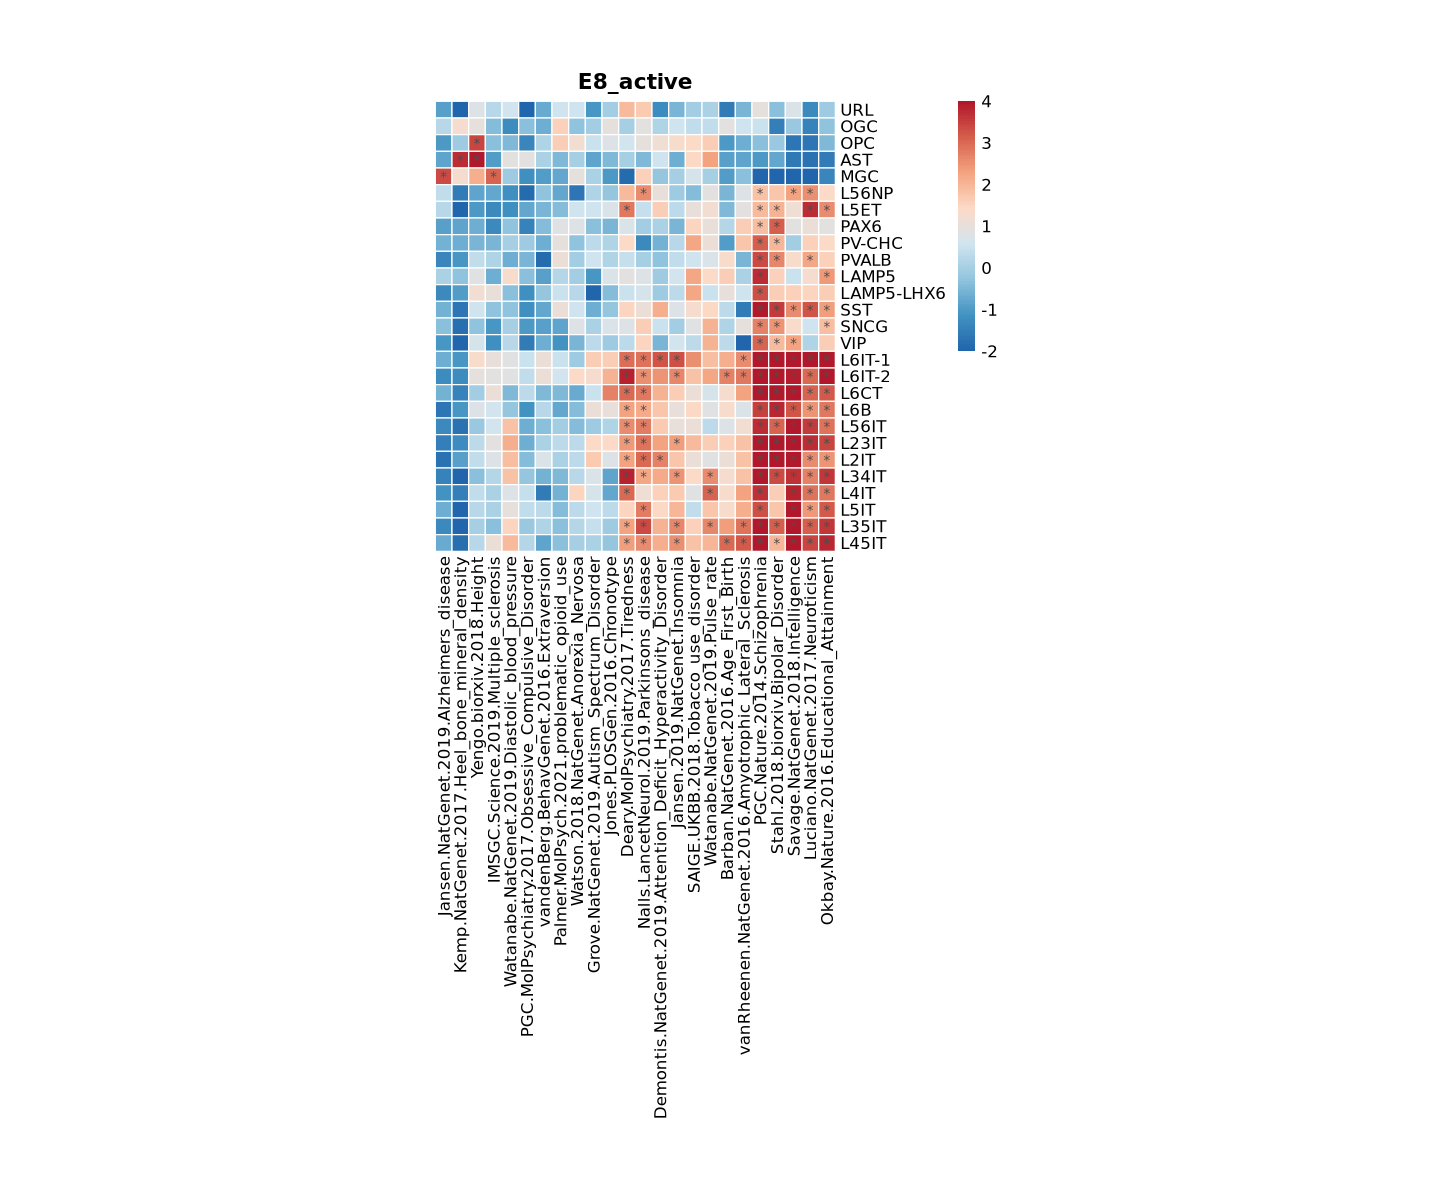

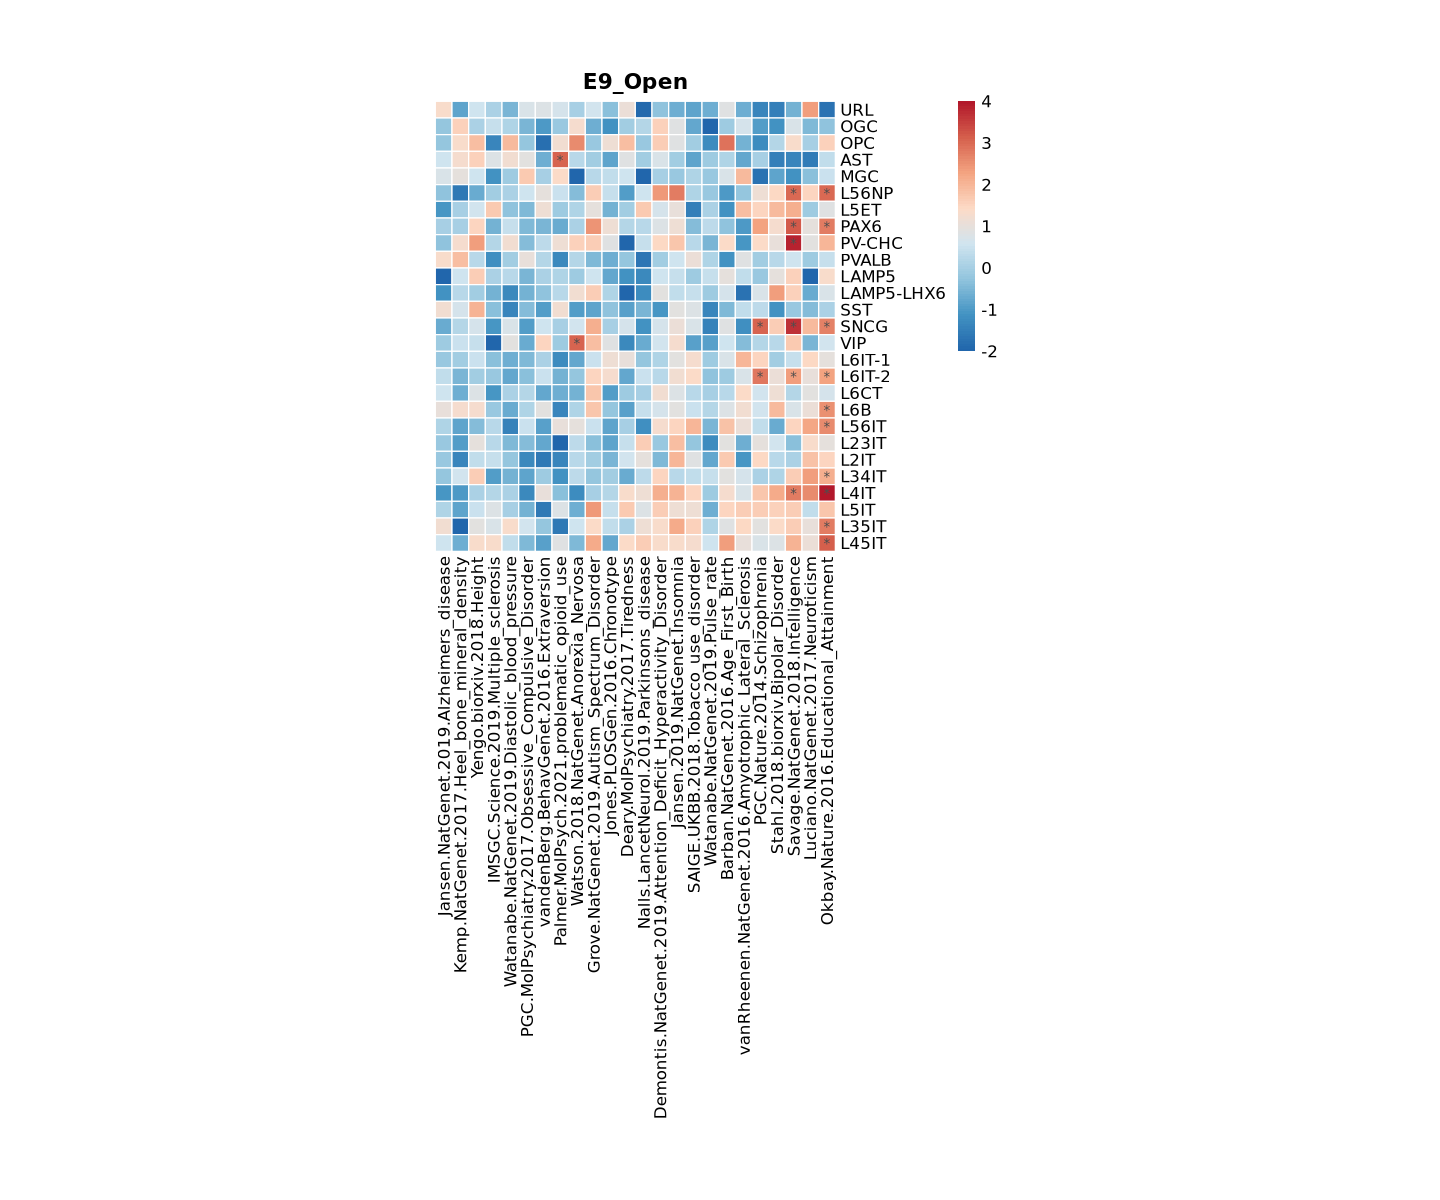

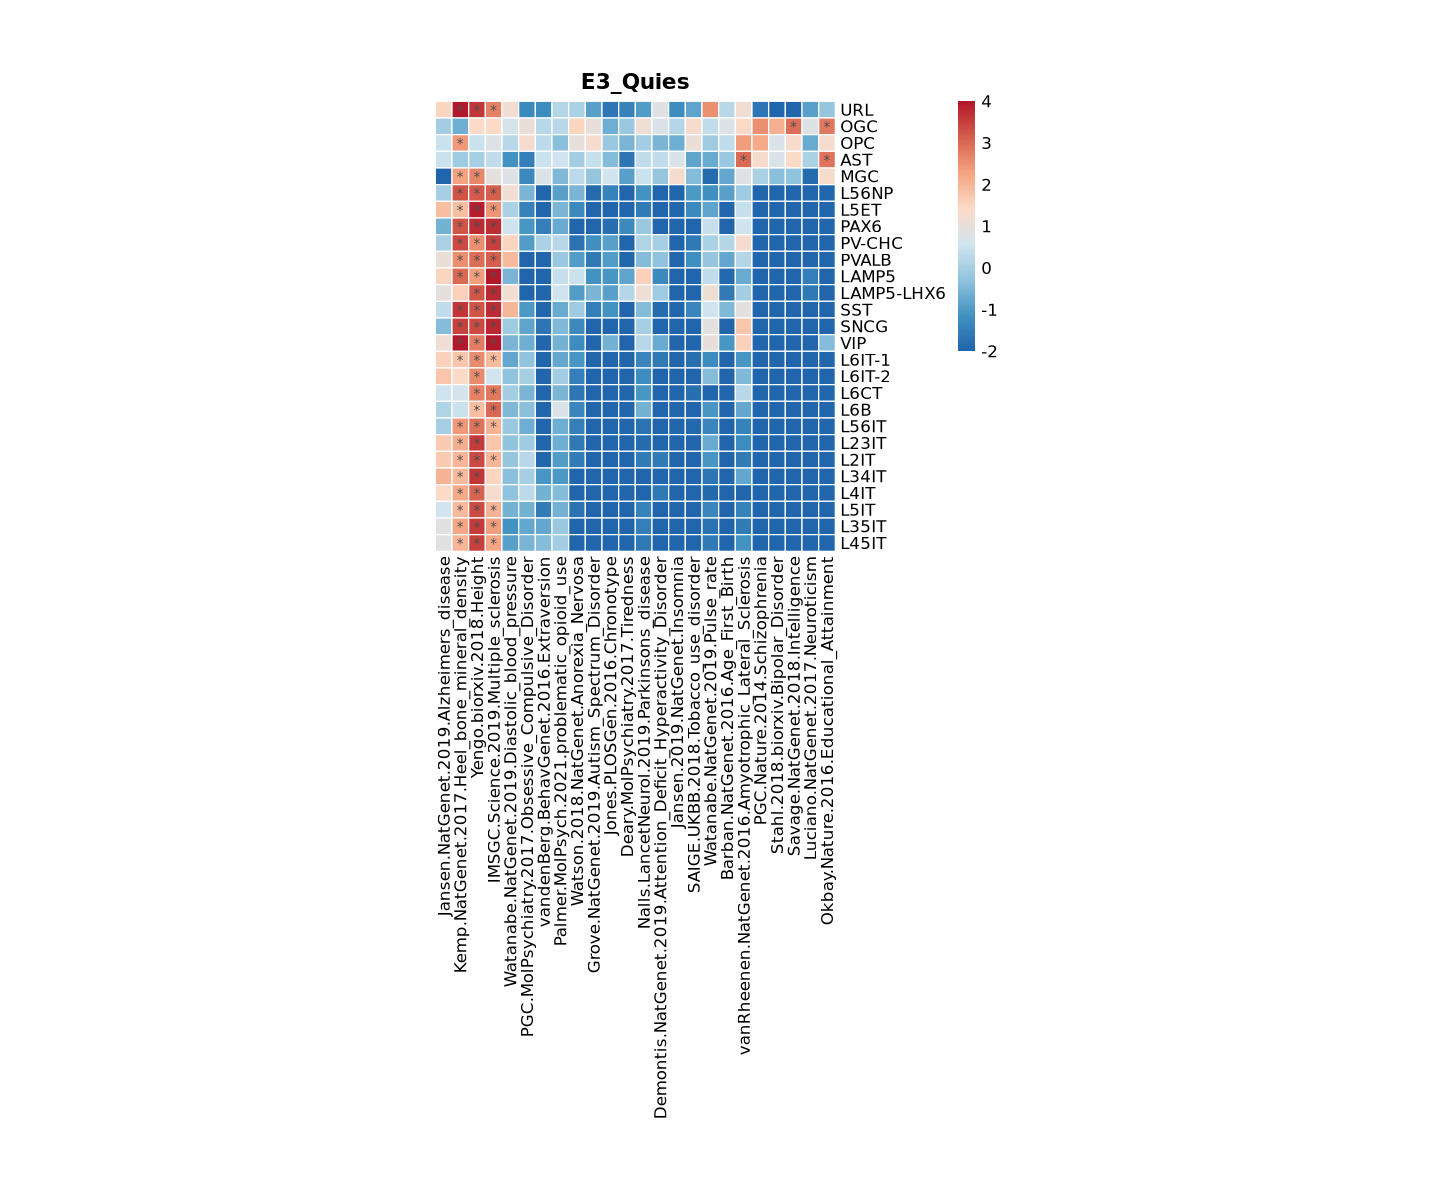

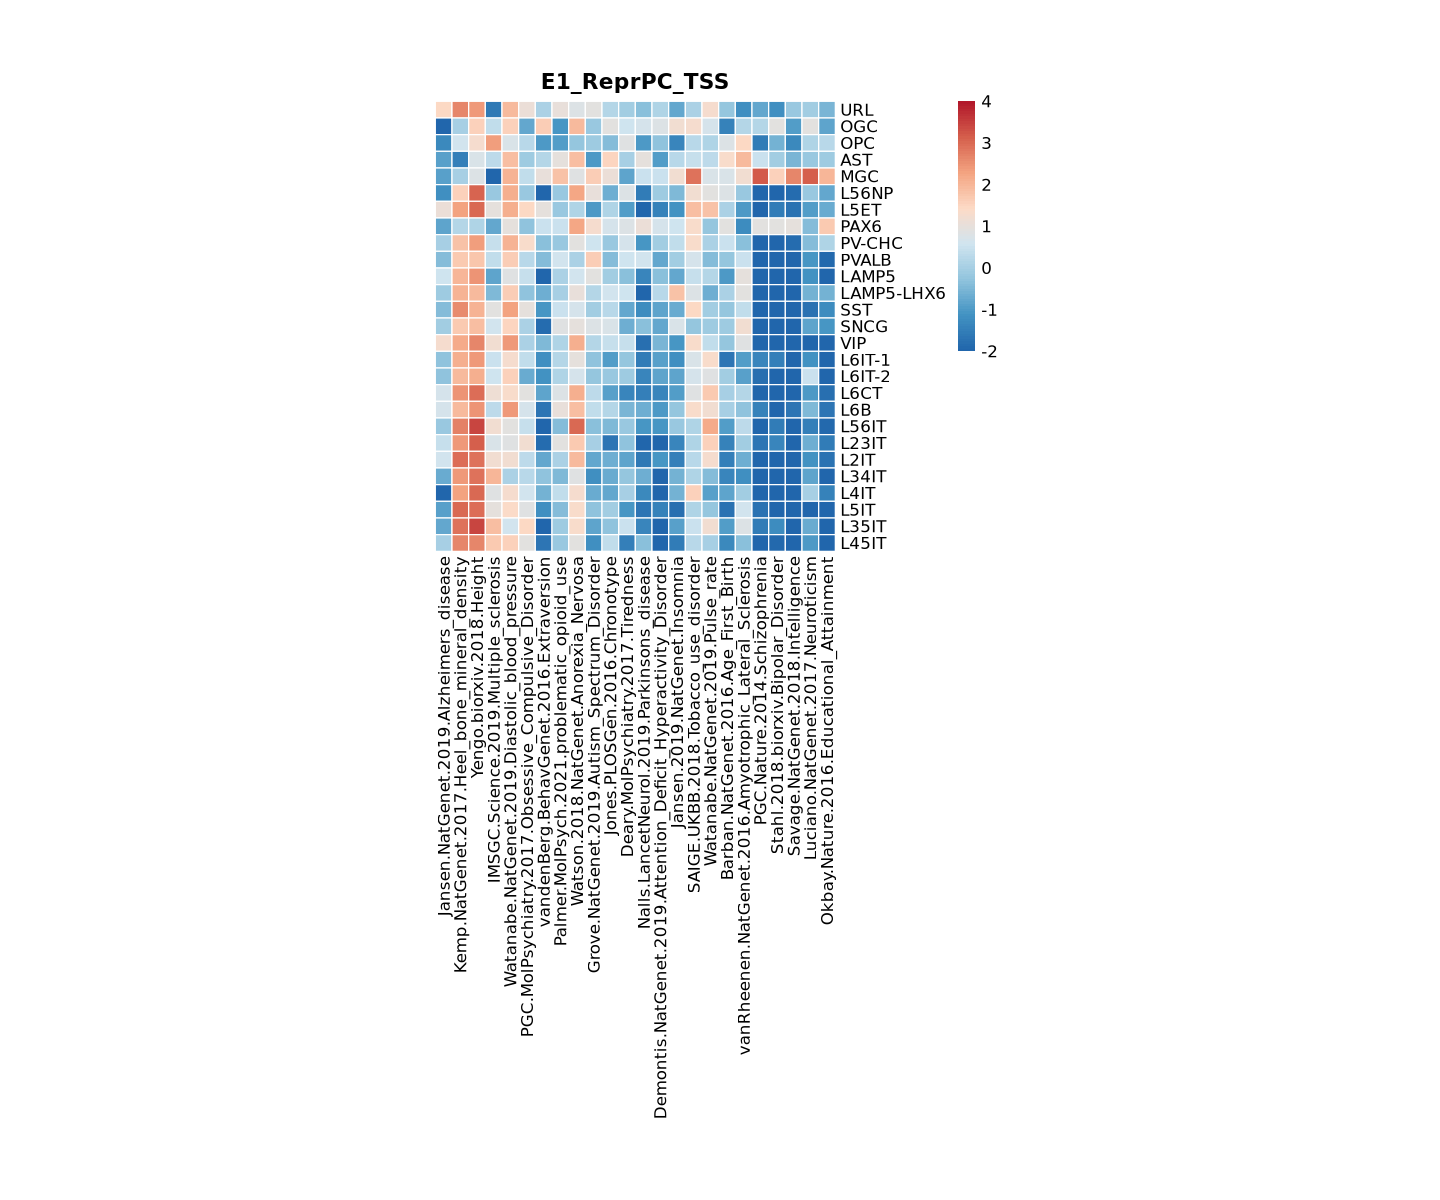

In [86]:
options(repr.plot.width = 12, repr.plot.height = 10)
t1 <- mtx[["E8"]] %>%
pheatmap(treeheight_col = 0, treeheight_row = 0, main = "E8_active",
         border_color = "white", display_numbers = lmat[["E8"]], 
         angle_col = 90, cellwidth = 10, cellheight = 10, 
         breaks = seq(-2, 4, 0.06),
         color = colorRampPalette(rev(brewer.pal(n = 8, name = "RdBu")))(100))

t2 <- mtx[["E9"]][t1$tree_row$labels[t1$tree_row$order], t1$tree_col$labels[t1$tree_col$order]] %>%
pheatmap(cluster_rows = F, cluster_cols = F,border_color = "white",  main = "E9_Open",
         display_numbers = lmat[["E9"]][t1$tree_row$labels[t1$tree_row$order], t1$tree_col$labels[t1$tree_col$order]], 
         angle_col = 90, cellwidth = 10, cellheight = 10, 
         breaks = seq(-2, 4, 0.06),
         color = colorRampPalette(rev(brewer.pal(n = 8, name = "RdBu")))(100))

t3 <- mtx[["E3"]][t1$tree_row$labels[t1$tree_row$order], t1$tree_col$labels[t1$tree_col$order]] %>%
pheatmap(cluster_rows = F, cluster_cols = F,border_color = "white", main = "E3_Quies",
         display_numbers = lmat[["E3"]][t1$tree_row$labels[t1$tree_row$order], t1$tree_col$labels[t1$tree_col$order]], 
         angle_col = 90, cellwidth = 10, cellheight = 10, 
         breaks = seq(-2, 4, 0.06),
         color = colorRampPalette(rev(brewer.pal(n = 8, name = "RdBu")))(100))

t4 <- mtx[["E1"]][t1$tree_row$labels[t1$tree_row$order], t1$tree_col$labels[t1$tree_col$order]] %>%
pheatmap(cluster_rows = F, cluster_cols = F,border_color = "white", main = "E1_ReprPC_TSS",
         display_numbers = lmat[["E2"]][t1$tree_row$labels[t1$tree_row$order], t1$tree_col$labels[t1$tree_col$order]], 
         angle_col = 90, cellwidth = 10, cellheight = 10, 
         breaks = seq(-2, 4, 0.06),
         color = colorRampPalette(rev(brewer.pal(n = 8, name = "RdBu")))(100))

### For specific traits like SCZ, compare coeffcients across states or subclasses

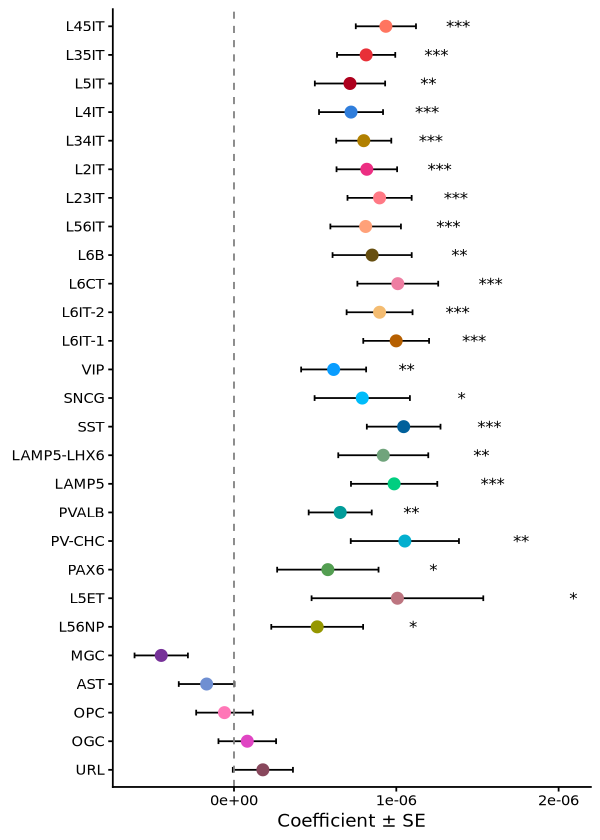

In [126]:
t2 <- do.call(rbind, glist) %>%
filter(!(Name %in% badcelltype)) %>%
group_by(chmm, group) %>%
mutate(FDR = p.adjust(Coefficient_P_value, method = "fdr")) %>%
mutate(sig = ifelse(FDR < 0.05, "*", "")) %>%
mutate(sig = ifelse(FDR < 0.005, "**", sig)) %>%
mutate(sig = ifelse(FDR < 0.0005, "***", sig)) %>%
ungroup %>%
filter(group == 'PGC.Nature.2014.Schizophrenia', chmm == "E8") %>%
mutate(Name = factor(Name, levels = t1$tree_row$labels[t1$tree_row$order])) %>%
ggplot(aes(y = Coefficient, x = Name)) + 
geom_errorbar(aes(ymin = Coefficient - Coefficient_std_error,
                ymax = Coefficient + Coefficient_std_error),
              width = 0.2) +
geom_point(size = 3, aes(color = Name)) +
geom_text(aes(label = sig, y = Coefficient + 2*Coefficient_std_error),
          hjust = 0, size = 3.5) +
geom_hline(yintercept = 0, linetype = "dashed", color = "gray50") +
theme_classic() + coord_flip() + scale_color_manual(values = ccol2) + 
labs(y = "Coefficient ± SE", x = NULL) + NoLegend()

options(repr.plot.width = 5, repr.plot.height = 7)
t2

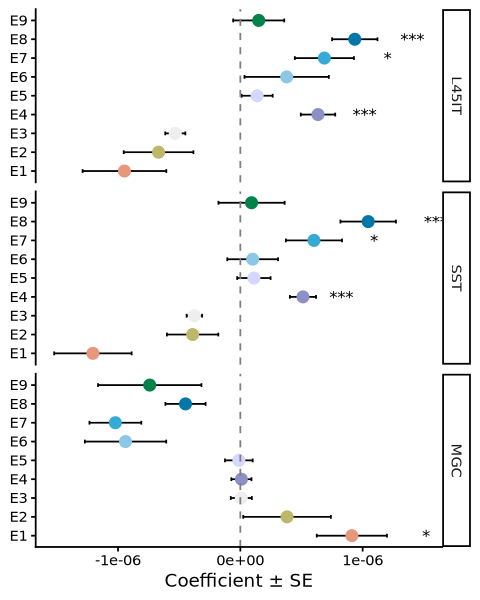

In [127]:
t3 <- do.call(rbind, glist) %>%
filter(!(Name %in% badcelltype)) %>%
group_by(chmm, group) %>%
mutate(FDR = p.adjust(Coefficient_P_value, method = "fdr")) %>%
mutate(sig = ifelse(FDR < 0.05, "*", "")) %>%
mutate(sig = ifelse(FDR < 0.005, "**", sig)) %>%
mutate(sig = ifelse(FDR < 0.0005, "***", sig)) %>%
ungroup %>%
filter(Name %in% c("L45IT", "SST", "MGC")) %>%
filter(group == 'PGC.Nature.2014.Schizophrenia') %>%
mutate(Name = factor(Name, levels = c("L45IT", "SST", "MGC"))) %>%
ggplot(aes(y = Coefficient, x = chmm)) + 
geom_errorbar(position = "dodge", aes(ymin = Coefficient - Coefficient_std_error,
                ymax = Coefficient + Coefficient_std_error),
              width = 0.2) +
geom_point(size = 3, aes(color = chmm)) +
geom_hline(yintercept = 0, linetype = "dashed", color = "gray50") +
geom_text(aes(label = sig, y = Coefficient + 2*Coefficient_std_error),
          hjust = 0, size = 3.5) +
theme_classic() + coord_flip() + scale_color_manual(values = chmstate$color) + 
labs(y = "Coefficient ± SE", x = NULL) + NoLegend() + 
facet_grid(Name ~ .)

options(repr.plot.width = 4, repr.plot.height = 5)
t3